# Challenge #1

This notebook contains the results of the Smarthelio challenge #1. It is divided in 4 main parts:

    1 PR temperature corrected cals based measured data
    2 PR temperature corrected cals based on estimated POA irradiance and module temperature
    3 Comparison between both PRs
    4 Clear sky moments identification (based on PVLib)

For more details in regards this results, please contact the author of this notebook.

NOTE: all the results here contained, are for the to be used exclusively for the Smarthelio challenge.

## 1 PR temperature corrected (measured data)

### Imports:

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns;sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
import sys
from os.path import join
%matplotlib inline

In [2]:
# define raw data file
file_ch1 = join(r"D:\Users\dguzmanr\Desktop\smarthelio\data\Challenge1.xlsx")
# define code path
sys.path.append(r"D:\Users\dguzmanr\Desktop\smarthelio\notebooks\code")

In [3]:
# import challenge 1 functions
import read_data
import calcs

### Read raw data and create DF

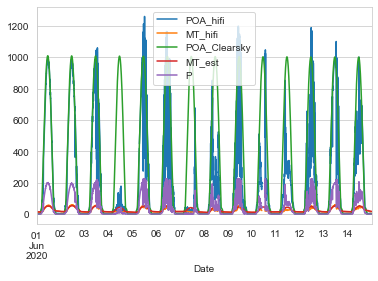

In [4]:
df = read_data.read_data(file_ch1)
df.plot()

### PR

In [5]:
pnom = 245  # according to the .xls file
temp_coef = -0.42  # according to the .xls file
df["PR"] = calcs.pr(df=df, 
                    p_col="P", 
                    irr_col="POA_hifi",
                    temp_col="MT_hifi",
                    pnom=pnom,
                    temp_coef=temp_coef)
df.head()

,POA_hifi,MT_hifi,POA_Clearsky,MT_est,P,ClearSky,PR
Date,,,,,,,
2020-06-01 00:00:00,4.170259,12.150000,0.0,14.433333,0.0,False,0.0
2020-06-01 00:01:00,4.202586,12.116667,0.0,14.420000,0.0,False,0.0
2020-06-01 00:02:00,4.148707,12.115000,0.0,14.406667,0.0,False,0.0
2020-06-01 00:03:00,4.123563,12.090000,0.0,14.393333,0.0,False,0.0
2020-06-01 00:04:00,4.076868,12.091667,0.0,14.380000,0.0,False,0.0


### Check plot

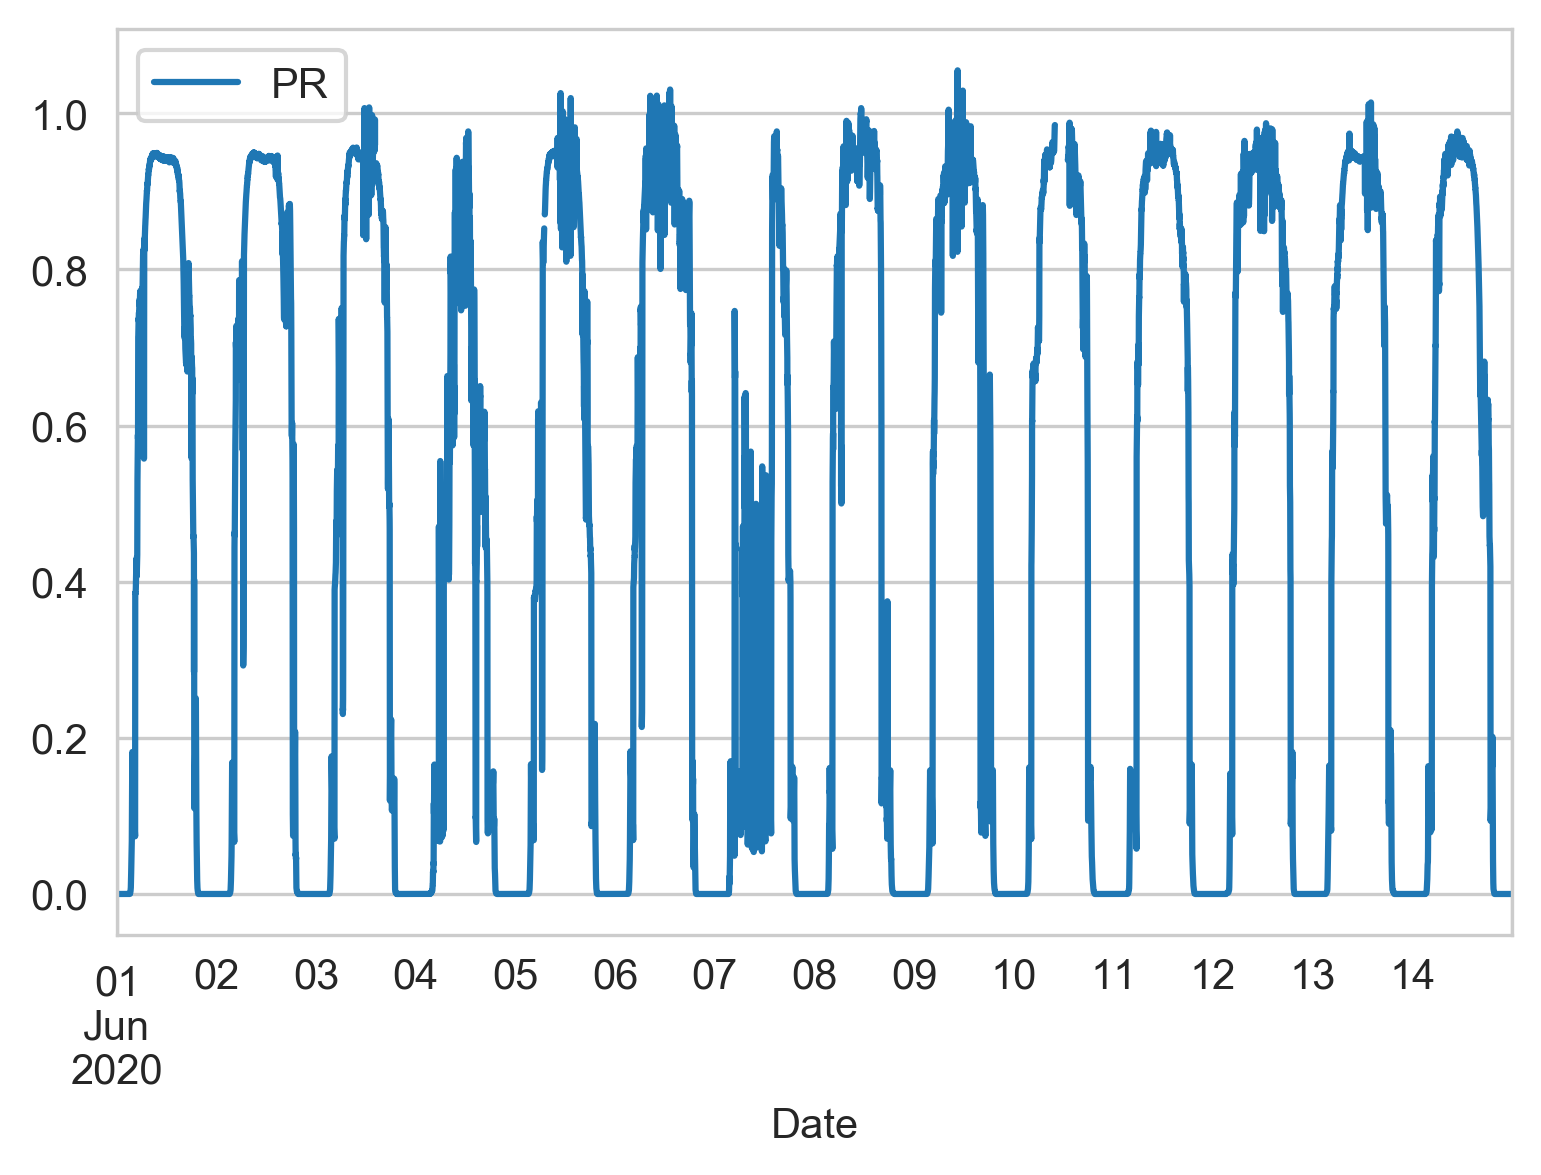

In [6]:
fig, axes = plt.subplots(dpi=300)
df.PR.plot()
plt.legend()

## 2 PR temperature corrected (estimated data)

### PR

In [7]:
# PR of estimated values
df["PR_est"] = calcs.pr(df=df, 
                        p_col="P", 
                        irr_col="POA_Clearsky",
                        temp_col="MT_est",
                        pnom=pnom,
                        temp_coef=temp_coef)
df.head()

,POA_hifi,MT_hifi,POA_Clearsky,MT_est,P,ClearSky,PR,PR_est
Date,,,,,,,,
2020-06-01 00:00:00,4.170259,12.150000,0.0,14.433333,0.0,False,0.0,NaN
2020-06-01 00:01:00,4.202586,12.116667,0.0,14.420000,0.0,False,0.0,NaN
2020-06-01 00:02:00,4.148707,12.115000,0.0,14.406667,0.0,False,0.0,NaN
2020-06-01 00:03:00,4.123563,12.090000,0.0,14.393333,0.0,False,0.0,NaN
2020-06-01 00:04:00,4.076868,12.091667,0.0,14.380000,0.0,False,0.0,NaN


### Check plot

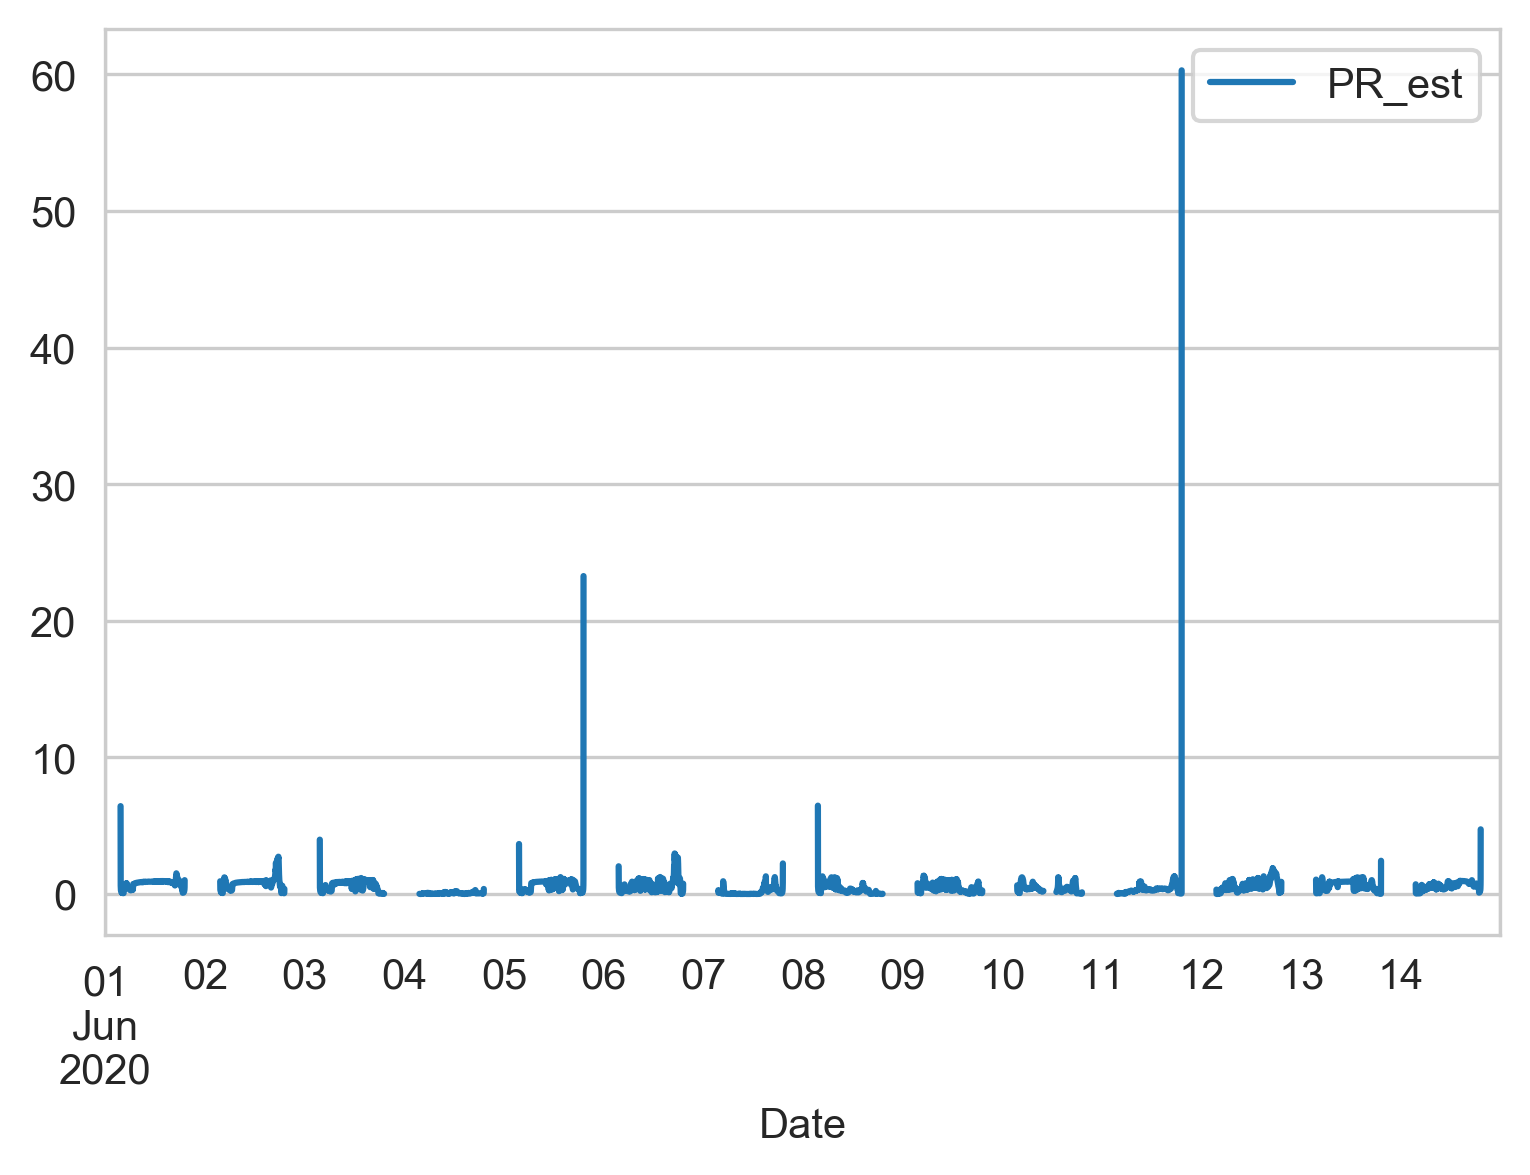

In [8]:
fig, axes = plt.subplots(dpi=300)
df.PR_est.plot()
plt.legend()

## 3 Comparison between PRs

From the results above we can infeer that:
    
    * the PR calculated with measured values is within the range of possible PR results
    * the PR caltulated with the estimated values is out of the range of possible PR results

normally, PR is between 0 and 1 values. However, under particular conditions it can be higher than 1 (ie. high irradiance reflections due to snow, water, etc.).

since PR values are given by the actual power generation/theoretical power geration: one can explain the differences in the values when checking for deviations in the irradiance and the temperature.

### Irradiance in POA difference

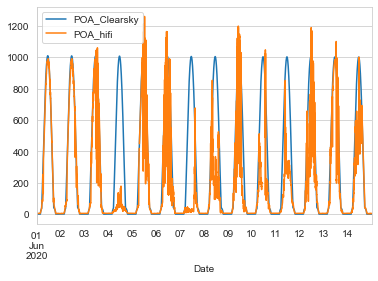

In [9]:
df.POA_Clearsky.plot()
df.POA_hifi.plot()
plt.legend()

### Module temperature difference

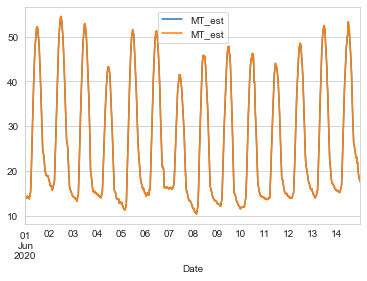

In [10]:
df.MT_est.plot()
df.MT_est.plot()
plt.legend()

### Thoughts

Looking at the plots, one can think that the main difference between the PR comes from the difference between the measured irradiance and the estimated one. It is clear that, Irradiance estimated is based on clear sky models which trust in perfect sky conditions at all times, which is not the real case (based on the measured irradiance).

In order to compare both PR in a more fair way, one can detect the clear sky moments on the measured irradiance and then compare again vs the PR (clear sky).

## Clear sky moment identification

Using a clear sky detect function from "_PVLib_" library, one can detect clear sky on measured irradiance or power. Important, note that the function has been developed to detect irradiance in a horizontal plane. However, it is possible to used irradiance (measured and clearsky estimated) in plane of array or even power but keep in mind that the results might not be optimal.

In [11]:
# import detect clear sky function from pvlib
from pvlib.clearsky import detect_clearsky

In [12]:
# Since the function is not designed for irradiance in POA, it is important to 
# optimize the parameters with trial and error
df["ck_detected"] = detect_clearsky(
    measured=df.POA_hifi,
    clearsky=df.POA_Clearsky,
    times=df.index,
    window_length=20,
    mean_diff=50,
    max_diff=50,
    lower_line_length=-5,
    upper_line_length=10,
    var_diff=.02,
    slope_dev=3,
    return_components=False).astype(int)
df.head()

,POA_hifi,MT_hifi,POA_Clearsky,MT_est,P,ClearSky,PR,PR_est,ck_detected
Date,,,,,,,,,
2020-06-01 00:00:00,4.170259,12.150000,0.0,14.433333,0.0,False,0.0,NaN,0
2020-06-01 00:01:00,4.202586,12.116667,0.0,14.420000,0.0,False,0.0,NaN,0
2020-06-01 00:02:00,4.148707,12.115000,0.0,14.406667,0.0,False,0.0,NaN,0
2020-06-01 00:03:00,4.123563,12.090000,0.0,14.393333,0.0,False,0.0,NaN,0
2020-06-01 00:04:00,4.076868,12.091667,0.0,14.380000,0.0,False,0.0,NaN,0


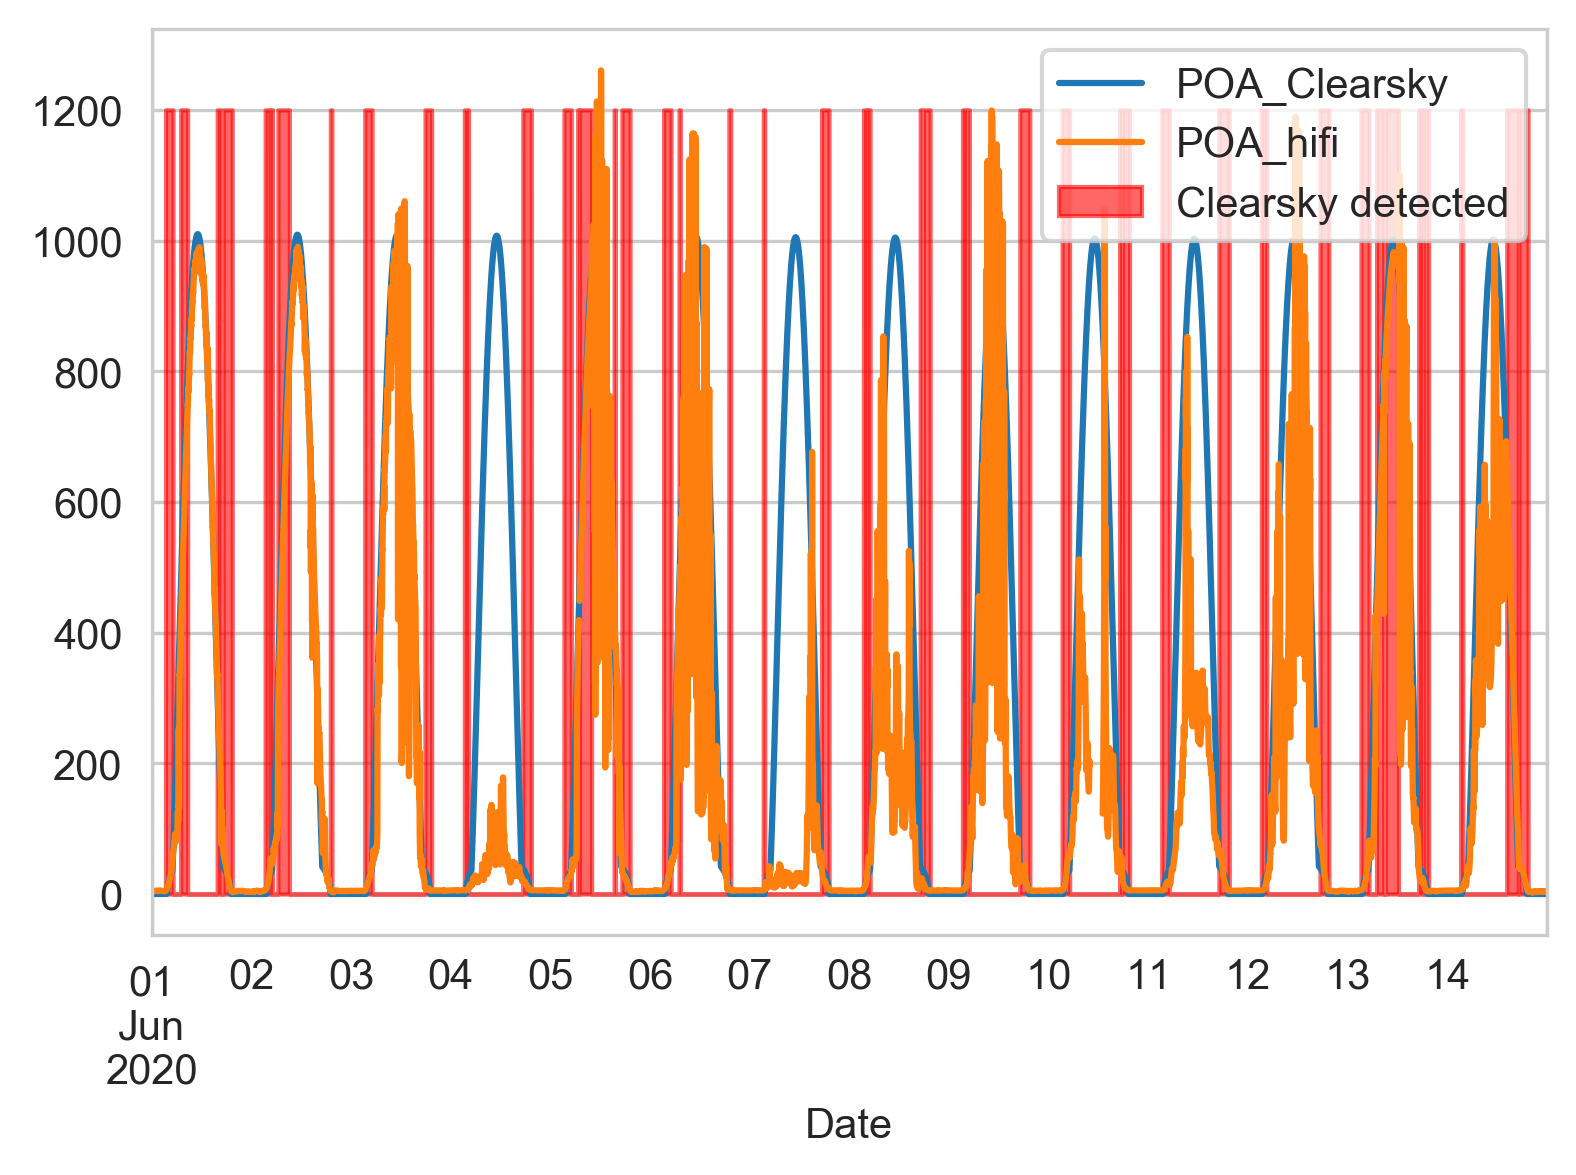

In [13]:
fig, axes = plt.subplots(dpi=300)
df.POA_Clearsky.plot()
df.POA_hifi.plot()
axes.fill_between(df.index,
                     (1200 * df.ck_detected.values),
                         alpha=0.6, label="Clearsky detected", color="red")
plt.legend()

Better results can be achieved by fine tunning the parameters of the _detect_clearsky_ function. If a filter is implemented based on the clear sky like moments detected then we get:

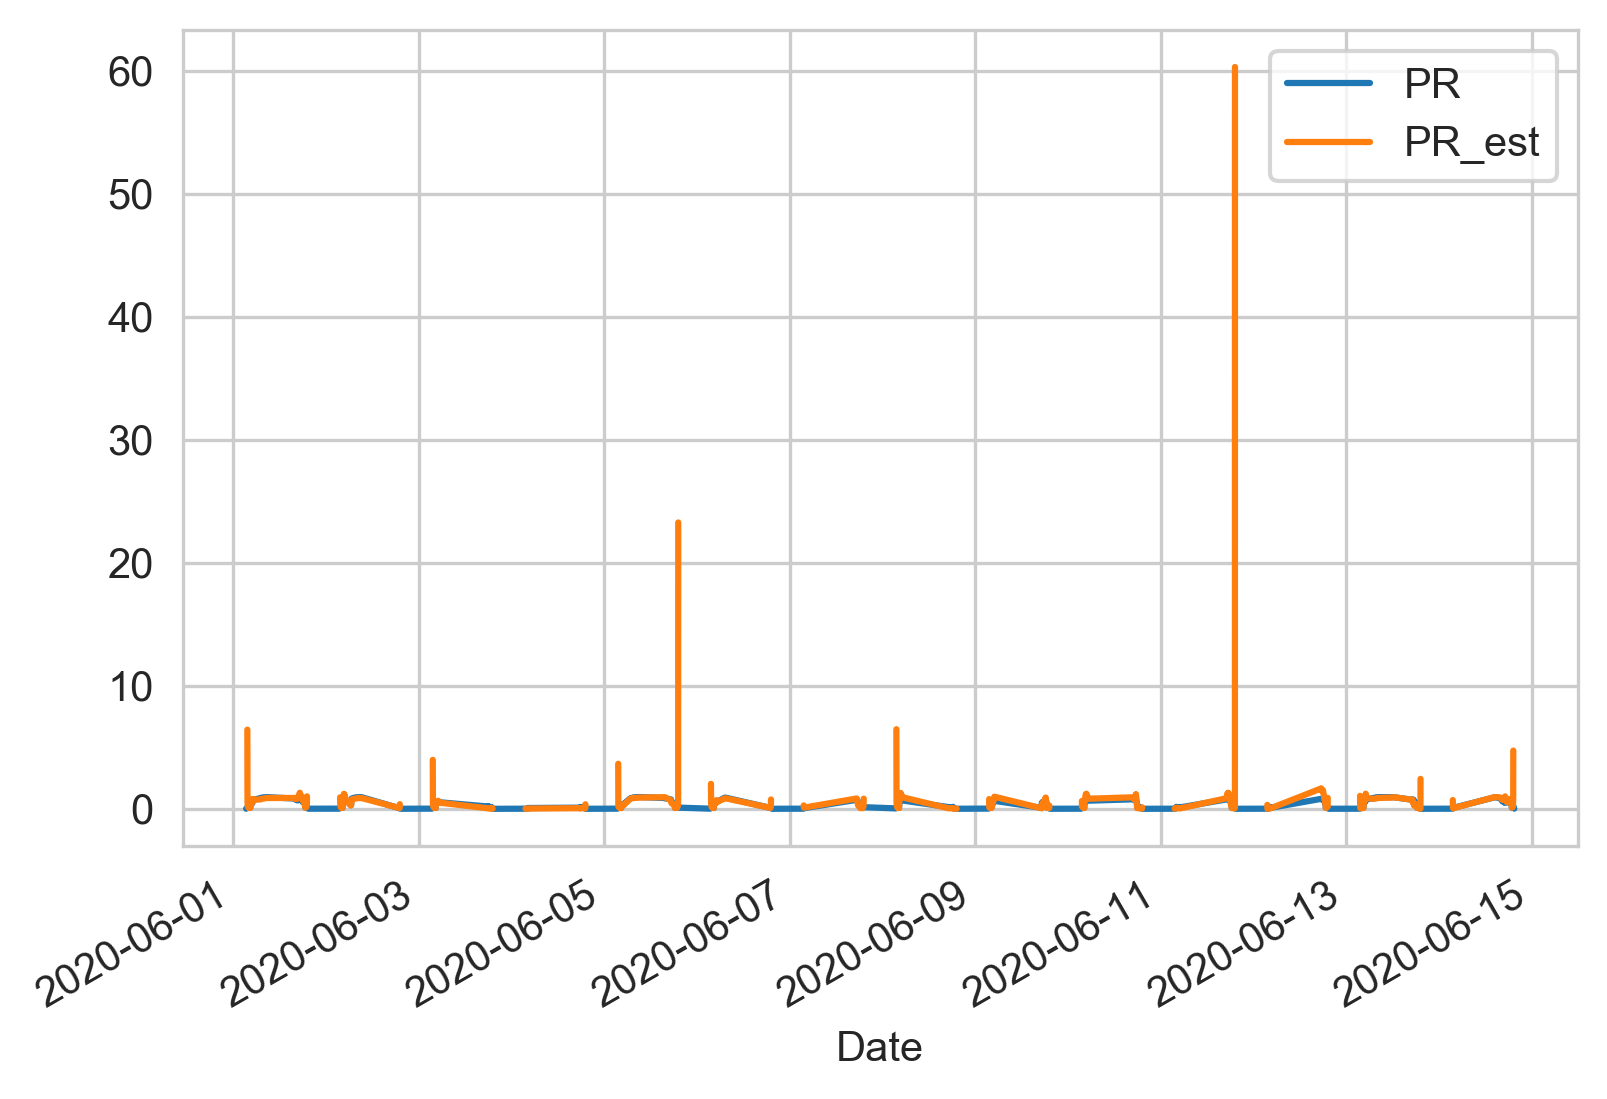

In [14]:
df_f = df.loc[np.array(df.ck_detected, dtype=bool)]
fig, axes = plt.subplots(dpi=300)
df_f.PR.plot()
df_f.PR_est.plot()
plt.legend()

PR values at lower irradiances can be tricky sometimes, one can fix that with the fine tunning of the function for clear sky detection, or simply by filtering irradiances higher than 200 W/m$^2$:

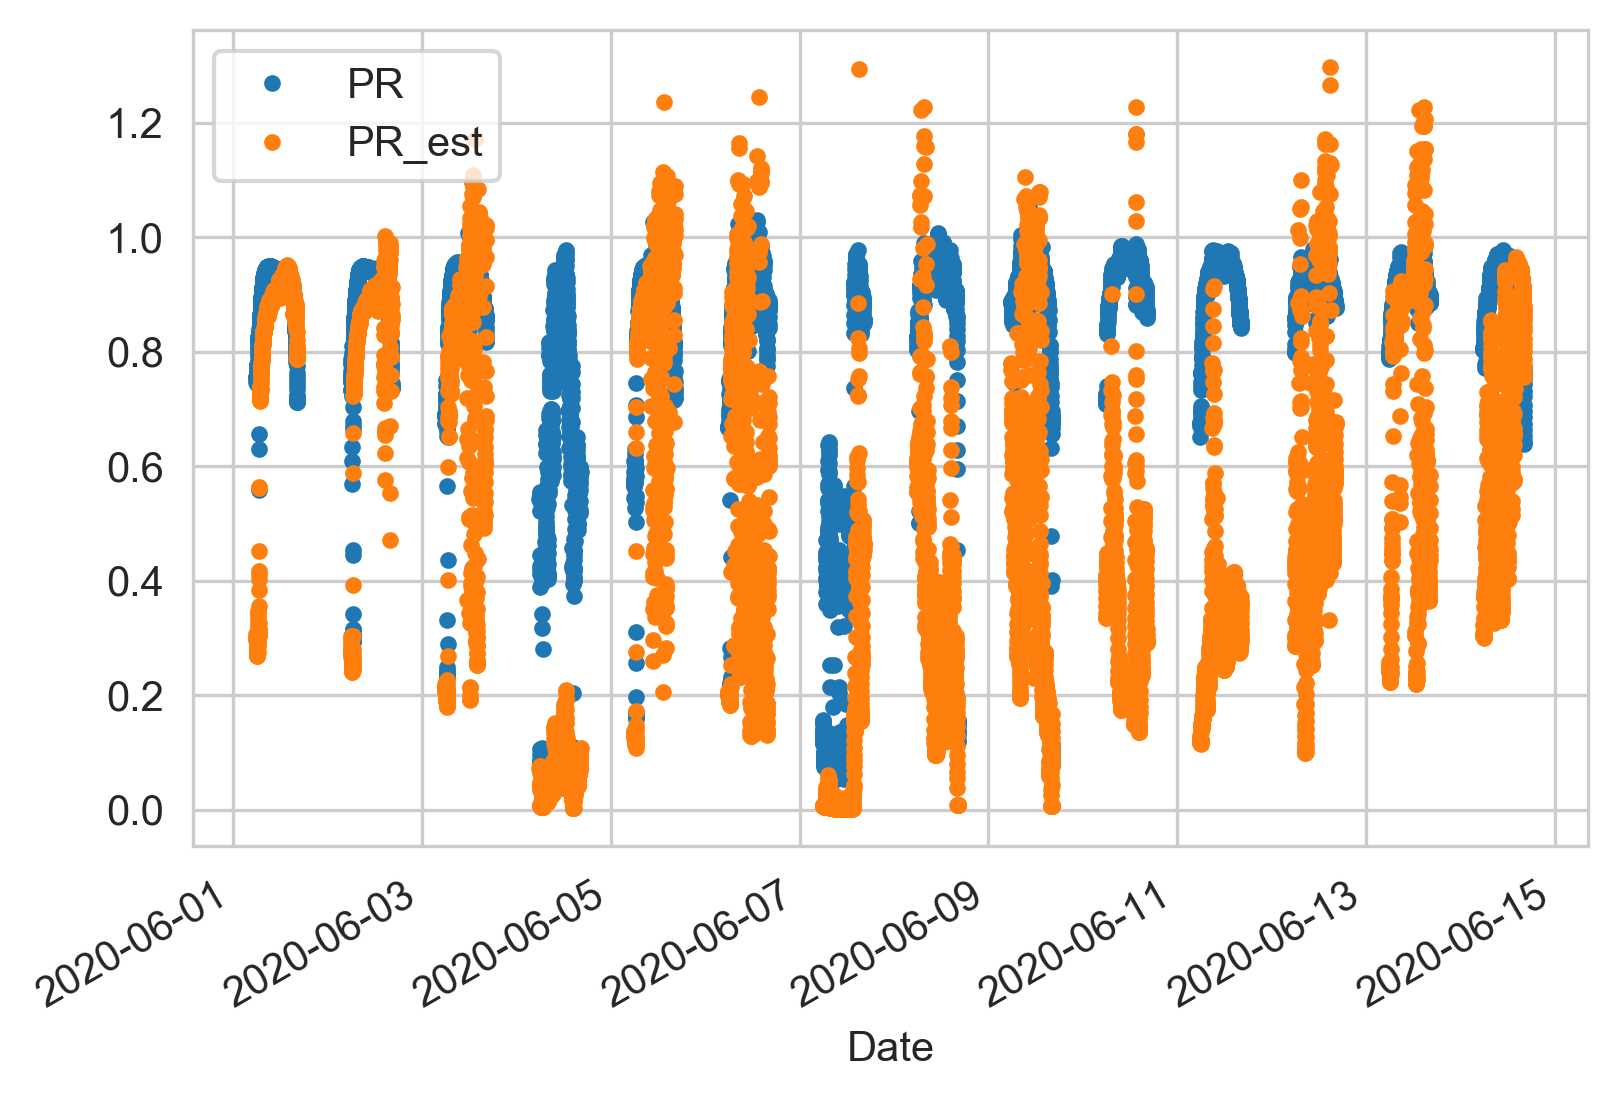

In [15]:
df_f = df.loc[df.POA_Clearsky > 200]
fig, axes = plt.subplots(dpi=300)
df_f.PR.plot(style=".")
df_f.PR_est.plot(style=".")
plt.legend()

## Personal conclusions:

In my personal poiunt of view, it is better to based the analysis on pure measured data. One has to be careful when using estimated values, mostly for such an importtan KPI.